# Load dataset
- The dataset should inherently include a column named "SMILES," and it must contain a single target column for prediction. If the column name containing the SMILES format is different, please assign the name of that column to the "smiles_col" argument.

In [1]:
from datasets import load_dataset
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

dataset = load_dataset("danielpark/smiles_plc50", "csv")
df = pd.DataFrame(dataset['train'])

Found cached dataset csv (C:/Users/parkm/.cache/huggingface/datasets/danielpark___csv/danielpark--smiles_plc50-1104076325aee32e/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


  0%|          | 0/1 [00:00<?, ?it/s]

In [2]:
df.head()

,SMILES,pIC50,num_atoms,logP
0,O=S(=O)(Nc1cccc(-c2cnc3ccccc3n2)c1)c1cccs1,4.26,25,4.1591
1,O=c1cc(-c2nc(-c3ccc(-c4cn(CCP(=O)(O)O)nn4)cc3)...,4.34,36,3.6743
2,NC(=O)c1ccc2c(c1)nc(C1CCC(O)CC1)n2CCCO,4.53,23,1.5361
3,NCCCn1c(C2CCNCC2)nc2cc(C(N)=O)ccc21,4.56,22,0.9510
4,CNC(=S)Nc1cccc(-c2cnc3ccccc3n2)c1,4.59,21,3.2130


# Scatter plot
- Using the original DataFrame as input, we visualize the distribution of numeric columns as scatter plots.

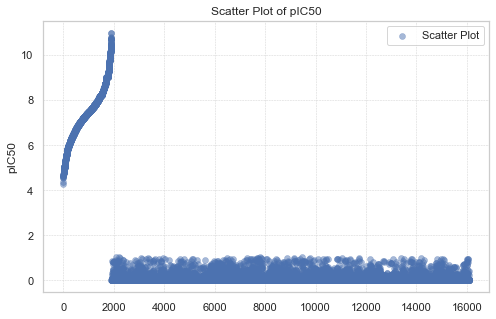

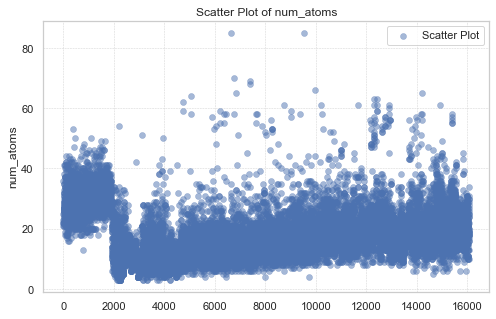

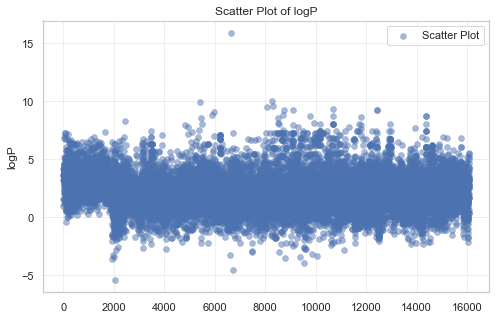

In [3]:
from smilesfeaturizer import df_scatter_plot

df_scatter_plot(df)

# Feature generation
- Create fingerprint columns for SMILES representations based on various packages like RDKit, Mol2Vec, DataMol, MolFeat, sklearn, etc.
- Generate various derived variables to enable ML expansion.
- By default, it uses the 'simple' method, but if you provide the 'specific' argument, it creates various functions based on MACCS, FPVec, ECFP, and RDKit 2D descriptors, represented with suffixes like 'ecfp_'.
- You can vectorize the given SMILES string based on various derived variables, and they are created as columns with one-hot encoding for ML suitability.

In [4]:
df = df[:100]
print(len(df.columns))
df.head()

4


,SMILES,pIC50,num_atoms,logP
0,O=S(=O)(Nc1cccc(-c2cnc3ccccc3n2)c1)c1cccs1,4.26,25,4.1591
1,O=c1cc(-c2nc(-c3ccc(-c4cn(CCP(=O)(O)O)nn4)cc3)...,4.34,36,3.6743
2,NC(=O)c1ccc2c(c1)nc(C1CCC(O)CC1)n2CCCO,4.53,23,1.5361
3,NCCCn1c(C2CCNCC2)nc2cc(C(N)=O)ccc21,4.56,22,0.9510
4,CNC(=S)Nc1cccc(-c2cnc3ccccc3n2)c1,4.59,21,3.2130


In [5]:
from smilesfeaturizer import generate_smiles_feature

df = generate_smiles_feature(df) # default method="simple"
print(len(df.columns))
df.head()

299


,SMILES,pIC50,num_atoms,logP,Molecule,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,fingerprint,3D_Coordinates,...,sas,n_aliphatic_carbocycles,n_aliphatic_heterocyles,n_aliphatic_rings,n_aromatic_carbocycles,n_aromatic_heterocyles,n_aromatic_rings,n_saturated_carbocycles,n_saturated_heterocyles,n_saturated_rings
0,O=S(=O)(Nc1cccc(-c2cnc3ccccc3n2)c1)c1cccs1,4.26,25,4.1591,<rdkit.Chem.rdchem.Mol object at 0x0000020FD84...,5,1,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[[4.730235378736627, -2.2900782673137003, 0.87...",...,2.094806,0,0,0,2,2,4,0,0,0
1,O=c1cc(-c2nc(-c3ccc(-c4cn(CCP(=O)(O)O)nn4)cc3)...,4.34,36,3.6743,<rdkit.Chem.rdchem.Mol object at 0x0000020FD84...,6,4,7,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[-7.812823742577332, 1.3125311786725888, -1.5...",...,2.997579,0,0,0,2,3,5,0,0,0
2,NC(=O)c1ccc2c(c1)nc(C1CCC(O)CC1)n2CCCO,4.53,23,1.5361,<rdkit.Chem.rdchem.Mol object at 0x0000020FD84...,5,3,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[5.097475154956845, -3.253216926634456, -0.29...",...,2.371007,1,0,1,1,1,2,1,0,1
3,NCCCn1c(C2CCNCC2)nc2cc(C(N)=O)ccc21,4.56,22,0.9510,<rdkit.Chem.rdchem.Mol object at 0x0000020FD84...,5,3,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0.20254311988543564, 5.183874190897031, -1.5...",...,2.420424,0,1,1,1,1,2,0,1,1
4,CNC(=S)Nc1cccc(-c2cnc3ccccc3n2)c1,4.59,21,3.2130,<rdkit.Chem.rdchem.Mol object at 0x0000020FD84...,3,2,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[5.810450509795463, 1.2264139383016035, 0.126...",...,2.020784,0,0,0,2,1,3,0,0,0


In [6]:
df = generate_smiles_feature(df, method="specific")
print(len(df.columns))
df.head()

[05:34:30] WARNING: not removing hydrogen atom without neighbors
[05:34:30] Initializing Normalizer
[05:34:30] Running Normalizer
[05:34:30] WARNING: not removing hydrogen atom without neighbors
[05:34:30] Initializing Normalizer
[05:34:30] Running Normalizer
[05:34:30] WARNING: not removing hydrogen atom without neighbors
[05:34:30] Initializing Normalizer
[05:34:30] Running Normalizer
[05:34:30] WARNING: not removing hydrogen atom without neighbors
[05:34:30] Initializing Normalizer
[05:34:30] Running Normalizer
[05:34:30] WARNING: not removing hydrogen atom without neighbors
[05:34:30] Initializing Normalizer
[05:34:30] Running Normalizer
[05:34:30] WARNING: not removing hydrogen atom without neighbors
[05:34:30] Initializing Normalizer
[05:34:30] Running Normalizer
[05:34:30] WARNING: not removing hydrogen atom without neighbors
[05:34:30] Initializing Normalizer
[05:34:30] Running Normalizer
[05:34:30] WARNING: not removing hydrogen atom without neighbors
[05:34:30] Initializing N

2703


,SMILES,pIC50,num_atoms,logP,Molecule,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,fingerprint,3D_Coordinates,...,maccs_157,maccs_158,maccs_159,maccs_160,maccs_161,maccs_162,maccs_163,maccs_164,maccs_165,maccs_166
0,O=S(=O)(Nc1cccc(-c2cnc3ccccc3n2)c1)c1cccs1,4.26,25,4.1591,<rdkit.Chem.rdchem.Mol object at 0x0000020FD98...,5,1,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[[3.6661911231256816, -0.6797624758494735, -2....",...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
1,O=c1cc(-c2nc(-c3ccc(-c4cn(CCP(=O)(O)O)nn4)cc3)...,4.34,36,3.6743,<rdkit.Chem.rdchem.Mol object at 0x0000020FD98...,6,4,7,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[-6.319298203185186, -1.7671647957539967, -3....",...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
2,NC(=O)c1ccc2c(c1)nc(C1CCC(O)CC1)n2CCCO,4.53,23,1.5361,<rdkit.Chem.rdchem.Mol object at 0x0000020FD98...,5,3,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[-4.6786600236080735, -3.969704152940455, 0.7...",...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
3,NCCCn1c(C2CCNCC2)nc2cc(C(N)=O)ccc21,4.56,22,0.9510,<rdkit.Chem.rdchem.Mol object at 0x0000020FD98...,5,3,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[-2.337231484640251, -4.683429366981909, -0.5...",...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
4,CNC(=S)Nc1cccc(-c2cnc3ccccc3n2)c1,4.59,21,3.2130,<rdkit.Chem.rdchem.Mol object at 0x0000020FD98...,3,2,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[-4.960215865383815, 1.9583086947873851, -0.5...",...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0


# Correlation heatmap
- Using derived variables generated based on the SMILES notation, we compare three correlation scores and visualize the top 10 highly correlated features.
- Similar to methodologies for calculating ELI5, SHAP values, or feature importance, this approach allows for a quick and straightforward assessment of multicollinearity and correlation from a data perspective.

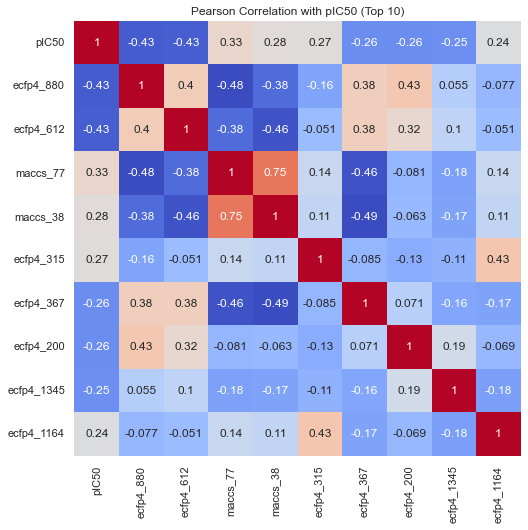

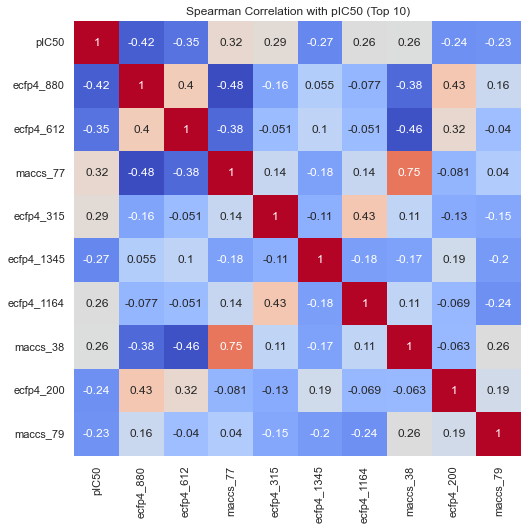

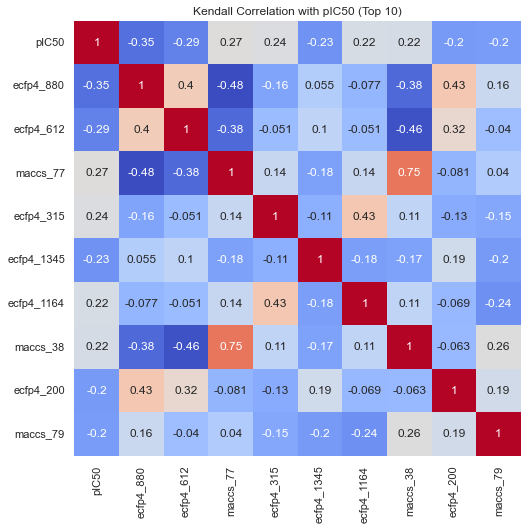

In [7]:
from smilesfeaturizer import draw_corr

draw_corr(df, "pIC50")

# Train machine learning model
- The utility of this package lies in providing fingerprints of SMILES strings with various derived variables, assisting in insights into researchers' datasets. 
- Therefore, it primarily examines very simple LGBM models. This process serves as a way to check for limitations, given that many tasks are insufficient and have discrete outcomes and data. 
- It can also be used as a supplementary tool for reviewing dashboards later.

The target column consists of continuous values, so we should use a regressor.
MSE on test set: 0.08


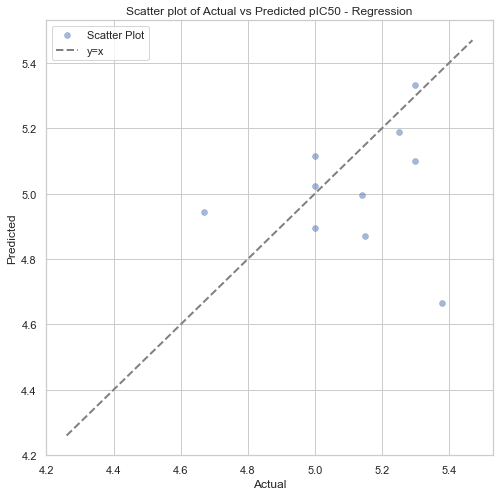

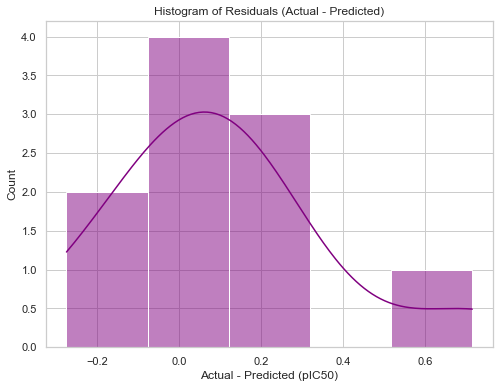

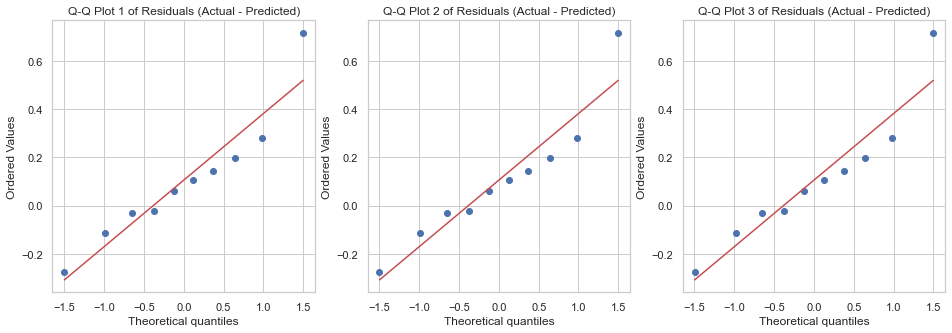

In [8]:
from smilesfeaturizer import train_lgbm

model, x_columns = train_lgbm(df, "pIC50")

In [9]:
df['predicted_pIC50'] = model.predict(df[x_columns])

# Create Dashboard 
- Through the dashboard, you can determine which compounds exhibit what prediction performance. 
- Researchers with domain knowledge can assess the prediction performance for specific molecules, identifying both good and poor performers, which can guide further modeling research.

In [10]:
from smilesfeaturizer import create_inline_dash_dashboard

# Load your DataFrame and specify the columns
true_col = 'pIC50'
predicted_col = 'predicted_pIC50'

# Create and run the Dash dashboard
create_inline_dash_dashboard(df, true_col, predicted_col)


# Save reporting images

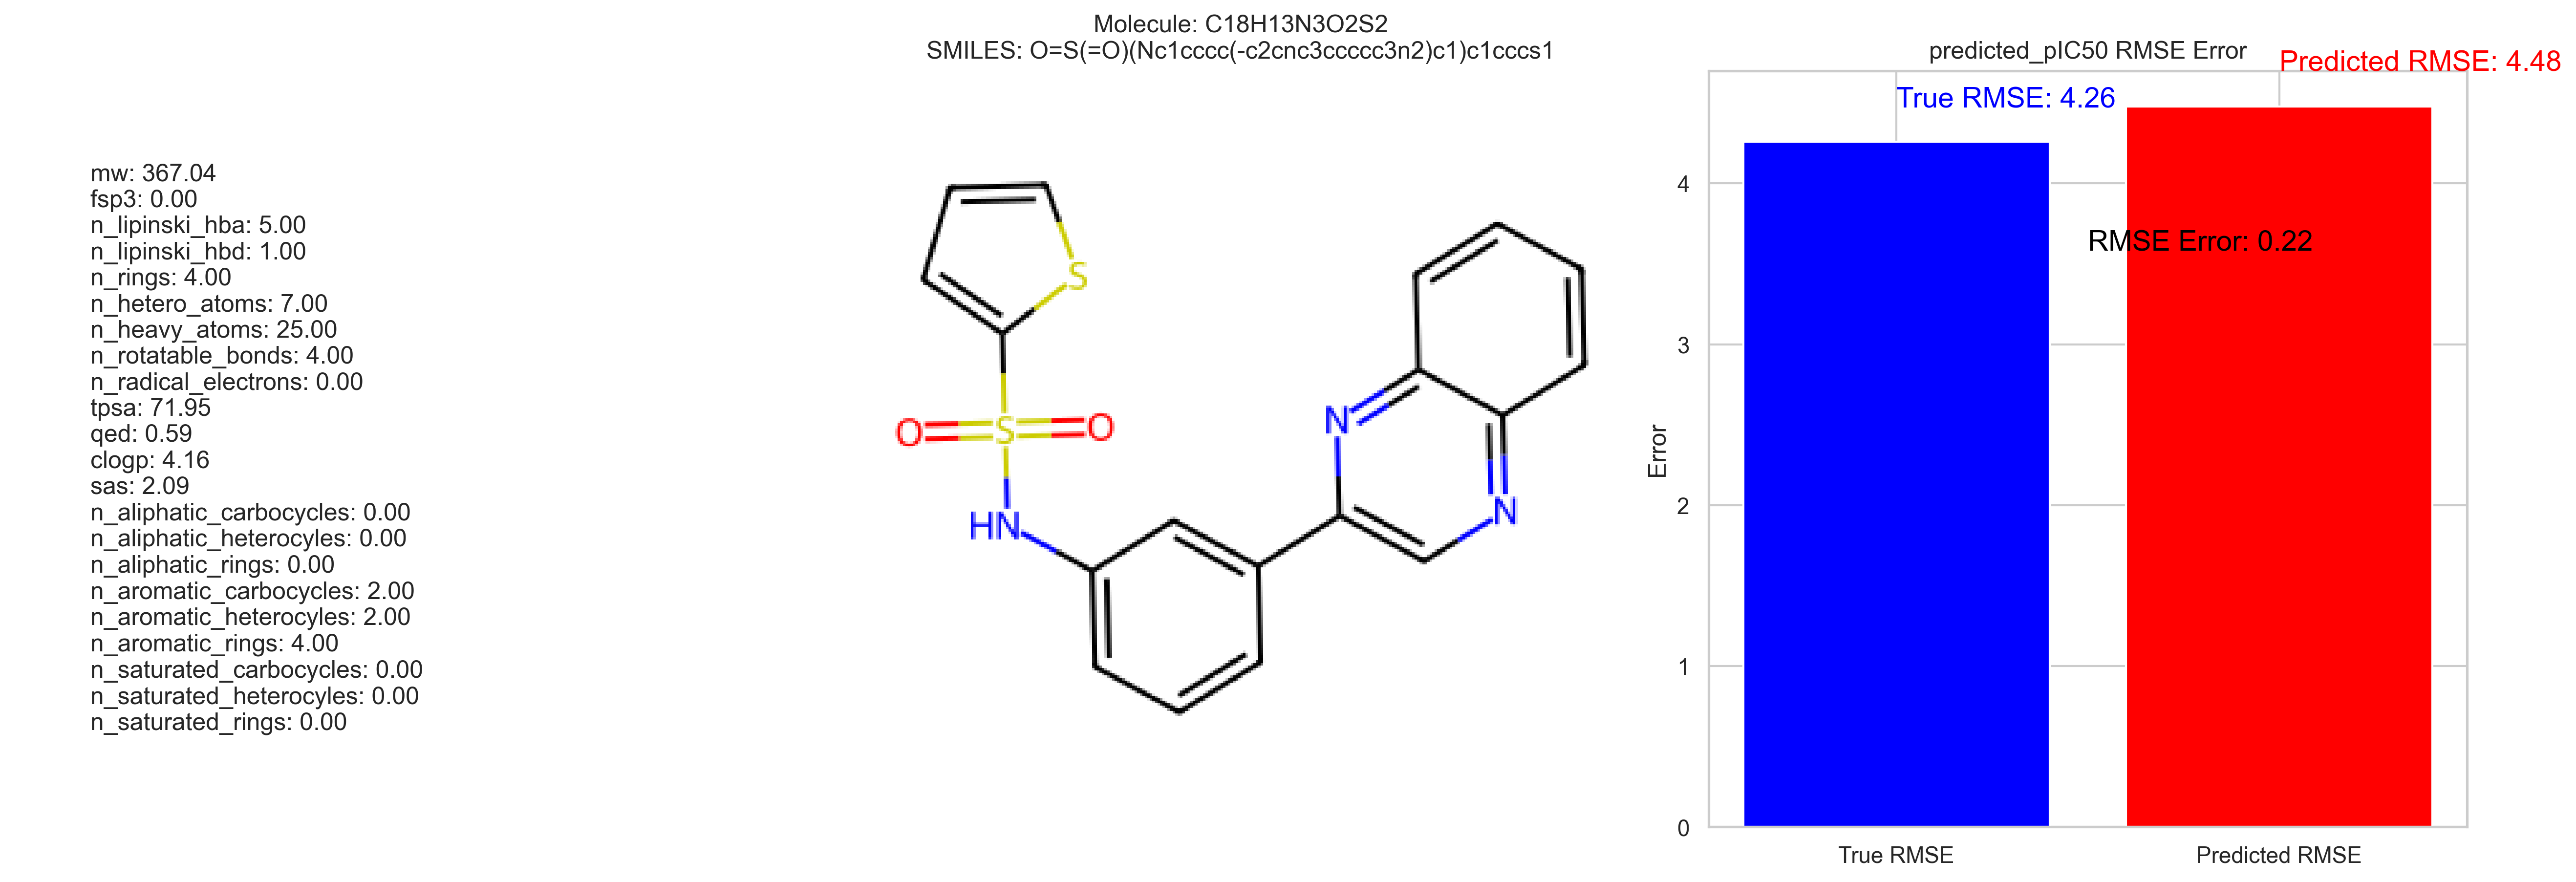

<Figure size 432x288 with 0 Axes>

In [11]:
from smilesfeaturizer import smiles_insight_plot
# Example usage
selected_metric = 'RMSE'  # Choose the error metric you want to display
true_column = 'pIC50'  # Replace with your true column name
predicted_column = 'predicted_pIC50'  # Replace with your predicted column name
smiles_insight_plot(df[:1], true_column, predicted_column, selected_metric, 'output_folder', show=True)